# Анализ тональности на английском:

In [1]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import torch

from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from tqdm import tqdm
from collections import defaultdict

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\romoc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romoc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romoc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


cuda


<Figure size 640x480 with 0 Axes>

In [2]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Загрузка данных

In [3]:
df_twitter = pd.read_csv('Tweets.csv',encoding='ISO-8859-1')
df = pd.read_csv('corona/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('corona/Corona_NLP_test.csv')
df_slang = pd.read_csv('slang/slang/slang.csv')
df_emoji = pd.read_csv('emoji/emoji_df.csv')

In [4]:
df_twitter = df_twitter.rename(columns={'selected_text': 'OriginalTweet', 'sentiment': 'Sentiment'})

In [6]:
df_twitter

,textID,text,OriginalTweet,Sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [7]:
#df_twitter[df_twitter['sentiment'] == 'neutral'].count
#df[df['Sentiment'] == 'Positive'].count
df_twitter['Sentiment'].unique()
#df['Sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [8]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
df_slang.head()

,Unnamed: 0,acronym,expansion
0,0,2day,today
1,1,2m2h,too much too handle
2,2,2moro,tomorrow
3,3,2nite,tonight
4,4,4eae,for ever and ever


In [10]:
df_emoji.head()

,emoji,name,group,sub_group,codepoints
0,😀,grinning face,Smileys & Emotion,face-smiling,1F600
1,😃,grinning face with big eyes,Smileys & Emotion,face-smiling,1F603
2,😄,grinning face with smiling eyes,Smileys & Emotion,face-smiling,1F604
3,😁,beaming face with smiling eyes,Smileys & Emotion,face-smiling,1F601
4,😆,grinning squinting face,Smileys & Emotion,face-smiling,1F606


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


# Очистка данных

In [15]:
df_twitter = df_twitter[['OriginalTweet','Sentiment']]

In [16]:
df = df[['OriginalTweet','Sentiment']]

In [17]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [18]:
df_twitter['Sentiment'] = df_twitter['Sentiment'].map({'negative':0,'neutral':1,'positive':2})
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

C:\Users\romoc\AppData\Local\Temp\ipykernel_4820\3667350502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter['Sentiment'] = df_twitter['Sentiment'].map({'negative':0,'neutral':1,'positive':2})


In [19]:
full_df = pd.concat([df_twitter[df_twitter['Sentiment'] == 1], df, df_test], ignore_index=True)
#full_df = pd.concat([df_twitter, df, df_test], ignore_index=True)
full_df['Sentiment'].value_counts()

Sentiment
2    19592
1    19450
0    17031
Name: count, dtype: int64

In [20]:
def limit_classes_to_n(df, class_column, n=1000):

    unique_classes = df[class_column].unique()
    
    limited_df = pd.DataFrame(columns=df.columns)
    
    for cls in unique_classes:

        class_rows = df.query(f"{class_column} == @cls")
        
        limited_class_rows = class_rows.head(n)
        
        limited_df = pd.concat([limited_df, limited_class_rows])
    
    return limited_df

full_df = limit_classes_to_n(full_df, 'Sentiment',  17031)
full_df['Sentiment'].value_counts()

Sentiment
1    17031
2    17031
0    17031
Name: count, dtype: int64

In [21]:
full_df = full_df.sample(frac=1).reset_index(drop=True)
full_df['Sentiment'].value_counts()

Sentiment
2    17031
1    17031
0    17031
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(full_df, test_size=0.1, stratify=full_df['Sentiment'])

In [23]:
df['Sentiment'].value_counts()

Sentiment
0    15328
1    15328
2    15327
Name: count, dtype: int64

In [24]:
def createDataset(df, textCol, labelCol):
  dataset_dict = {
    'text' : df[textCol],
    'labels' : df[labelCol],
  }
  sent_tags = ClassLabel(num_classes=3 , names=[ 'Negative','Neutral','Positive'])

  return Dataset.from_dict(
    mapping = dataset_dict,
    features = Features({'text' : Value(dtype='string') , 'labels' :sent_tags})
  )

In [25]:
print(df.shape , df_test.shape)
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED, stratify=df['Sentiment'])
print(df_train.shape , df_val.shape, df_test.shape)

(45983, 2) (5110, 2)
(41384, 2) (4599, 2) (5110, 2)


In [26]:
dataset_train = createDataset(df_train,"OriginalTweet","Sentiment")
dataset_val = createDataset(df_val,"OriginalTweet","Sentiment")
dataset_test = createDataset(df_test,"OriginalTweet","Sentiment")

dataset_sentAnalysis = DatasetDict()
dataset_sentAnalysis["train"] = dataset_train
dataset_sentAnalysis["val"] = dataset_val
dataset_sentAnalysis["test"] = dataset_test

dataset_sentAnalysis

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 41384
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 4599
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5110
    })
})

In [27]:
emoji_dict = dict(zip(df_emoji['emoji'], df_emoji['name']))
slang_dict = dict(zip(df_slang['acronym'], df_slang['expansion']))


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


def convert_to_lower(text):
    return text.lower()

def replace_emoji_with_words(text):
    for emj, desc in emoji_dict.items():
        text = text.replace(emj, f" {desc} ")
    return text

def replace_slang_with_full_form(text):
    words = text.split()
    new_words = [slang_dict.get(word.lower(), word) for word in words]
    return ' '.join(new_words)


def remove_extra_white_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def preprocessText(text):
    text = convert_to_lower(text)
    text = replace_emoji_with_words(text)
    text = replace_slang_with_full_form(text)
    text = remove_punctuation(text)
    text = remove_extra_white_spaces(text)
    return text

def preprocessBatch(batch):

    processed_texts = []

    for text in batch["text"]:

        text = convert_to_lower(text)
        text = replace_emoji_with_words(text)
        text = replace_slang_with_full_form(text)
        text = remove_punctuation(text)
        text = remove_extra_white_spaces(text)


        processed_texts.append(text)

    batch["text"] = processed_texts
    return batch

In [28]:
dataset_sentAnalysis_preprocessed = dataset_sentAnalysis.map(preprocessBatch, batched=True, batch_size=32)

Map:   0%|          | 0/41384 [00:00<?, ? examples/s]

Map:   0%|          | 0/4599 [00:00<?, ? examples/s]

Map:   0%|          | 0/5110 [00:00<?, ? examples/s]

In [29]:
text = "This game is dope! 🎮 Lmk when you're online!"

processed_text = preprocessText(text)
print("Оригинал:", text)
print("После обработки:", processed_text)

Оригинал: This game is dope! 🎮 Lmk when you're online!
После обработки: this game is dope video game let me know when youre online


In [30]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [31]:
max_len = 256
def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=max_len)

In [32]:
sample_text = "What is  going on @resturant.:( It makes   Me Feel Upset.😞"
tokens = tokenizer.tokenize(sample_text)
print(len(tokens), tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids), token_ids)

token_dictionary = tokenizer(sample_text)
print(token_dictionary)
print(len(token_dictionary.input_ids)) 

tokens = tokenizer.convert_ids_to_tokens(token_dictionary['input_ids'])
print(tokens)

token_encode = tokenizer.encode(sample_text) 
print(token_encode)

18 ['what', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'it', 'makes', 'me', 'feel', 'upset', '.', '[UNK]']
18 [2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006, 2009, 3084, 2033, 2514, 6314, 1012, 100]
{'input_ids': [101, 2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006, 2009, 3084, 2033, 2514, 6314, 1012, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
20
['[CLS]', 'what', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'it', 'makes', 'me', 'feel', 'upset', '.', '[UNK]', '[SEP]']
[101, 2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006, 2009, 3084, 2033, 2514, 6314, 1012, 100, 102]


In [33]:
print(tokenizer)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [34]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)
encoding

{'input_ids': tensor([[ 101, 2054, 2003, 2183, 2006, 1030, 2717, 4648, 3372, 1012, 1024, 1006,
         2009, 3084, 2033, 2514, 6314, 1012,  100,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

In [35]:
dataset_sentAnalysis_encoded = dataset_sentAnalysis_preprocessed.map(tokenize, batched=True, batch_size=32)

Map:   0%|          | 0/41384 [00:00<?, ? examples/s]

Map:   0%|          | 0/4599 [00:00<?, ? examples/s]

Map:   0%|          | 0/5110 [00:00<?, ? examples/s]

In [36]:
dataset_sentAnalysis_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 41384
    })
    val: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4599
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5110
    })
})

# Даталоадер


In [37]:
from torch.utils import data
class SentimentDataset(data.Dataset):

  def __init__(self, text, targets, tokenizer, max_len=512, transform=None):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.transform = transform

  def __len__(self):
    return len(self.text)

  def __getitem__(self,itemInd):
    text =  str(self.text[itemInd])

    text = preprocessText(text)

    if self.transform:
        text = self.transform(self.text)

    encoding = tokenizer.encode_plus(
        text,
        max_length=self.max_len,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors="pt"
    )


    return {
        'text': text,
        'input_ids': encoding["input_ids"].flatten(),
        'attention_mask': encoding["attention_mask"].flatten(),
        'targets': torch.tensor(self.targets[itemInd], dtype=torch.long)
    }

def create_dataloader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        text = df["OriginalTweet"].to_numpy(),
        targets = df["Sentiment"].to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return data.DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 0
    )

In [39]:
batch_size = 16

train_data_loader = create_dataloader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_dataloader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_dataloader(df_test, tokenizer, max_len, batch_size)
it = iter(train_data_loader)
data_batch = next(it)
data_batch.keys()

print(data_batch["input_ids"].shape, data_batch["attention_mask"].shape, data_batch["targets"].shape)
data_batch["input_ids"][0]

torch.Size([8, 256]) torch.Size([8, 256]) torch.Size([8])


tensor([  101,  2156,  2053,  4763,  4626,  2088,  4843,  4024, 10706,  8472,
         2017,  2323,  3422,  2592,  2974,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

# Моделька


In [40]:
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

      
        self.bert = BertModel(config)
  
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.post_init()


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):

        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)


        sequence_output = self.dropout(outputs[1])
        logits = self.classifier(sequence_output)

   
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
  
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [41]:
from transformers import AutoConfig

id2label = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
}

label2id = { v:k for (k,v) in id2label.items()}

bert_config = AutoConfig.from_pretrained('bert-base-uncased',
                                         num_labels=3,
                                         id2label=id2label, label2id=label2id)

In [42]:
bert_model = (BertForClassification
              .from_pretrained('bert-base-uncased', config=bert_config).to(device))

Some weights of BertForClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Тренировочка

In [43]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [44]:
from torch.optim import AdamW
from transformers import get_scheduler

lr=2e-5
optimizer = AdamW(bert_model.parameters(), lr=lr)

num_epochs = 5

logging_steps = len(dataset_sentAnalysis_encoded["train"]) // batch_size
num_training_steps = num_epochs * logging_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [45]:
loss_fct = nn.CrossEntropyLoss().to(device)

In [46]:
from tqdm.notebook import tqdm

def eval_op(model, data_loader, loss_fn, n_examples):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
      for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, targets)
        correct_predictions += torch.sum(preds.indices == targets)
        losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  n_examples,
  scheduler=None
):


  model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device) 
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    preds = torch.max(outputs.logits, dim=1)


    loss = loss_fn(outputs.logits, targets)
    correct_predictions += torch.sum(preds.indices == targets)
    losses.append(loss.item())
    loss.backward()
    


    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    optimizer.zero_grad()




  return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(num_epochs)):
  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    bert_model,
    train_data_loader,
    loss_fct,
    optimizer,
    len(df_train),
    scheduler=lr_scheduler
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_op(
    bert_model,
    val_data_loader,
    loss_fct,
    len(df_val)
  )
  print(f'Val loss {val_loss} accuracy {val_acc}')
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save({
            'epoch': epoch,
            'model_state_dict': bert_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss
            }, f'./bert-eng.bin')
    best_accuracy = val_acc

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
----------
Train loss 0.4497749729112324 accuracy 0.8483955151749468
Val loss 0.35300193503499033 accuracy 0.8999782561426397
Epoch 2/5
----------
Train loss 0.29681643720773354 accuracy 0.923811134738063
Val loss 0.37371920640499373 accuracy 0.9071537290715372
Epoch 3/5
----------
Train loss 0.2151951792041079 accuracy 0.9502947999226754
Val loss 0.38553143974059545 accuracy 0.913676886279626
Epoch 4/5
----------
Train loss 0.17118757128899803 accuracy 0.9622317803982214
Val loss 0.44168270895166484 accuracy 0.9123722548380082
Epoch 5/5
----------
Train loss 0.13662343922116094 accuracy 0.9706408273728977
Val loss 0.4249577544700435 accuracy 0.9191128506196999
CPU times: total: 1h 45min 39s
Wall time: 1h 46min 25s


In [49]:
test_acc, test_loss = eval_op(bert_model, test_data_loader, loss_fct, len(df_test))
test_acc, test_loss

(tensor(0.9184, device='cuda:0', dtype=torch.float64),
 np.float64(0.42763198905275385))

In [50]:
def get_text(model, data_loader):

  model = model.eval()
  texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _,preds = torch.max(outputs.logits, dim=1)
      
      texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs.logits)
      real_values.extend(targets)


  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return texts, predictions, prediction_probs, real_values

In [51]:
y_texts, y_pred, y_probs, y_test = get_text(bert_model, test_data_loader)

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = [ 'Negative','Neutral', 'Positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.92      0.89      0.91      1703
     Neutral       0.94      0.94      0.94      1703
    Positive       0.90      0.92      0.91      1704

    accuracy                           0.92      5110
   macro avg       0.92      0.92      0.92      5110
weighted avg       0.92      0.92      0.92      5110



In [59]:
class_names = [ 'Negative','Neutral', 'Positive']
#class_names = [ 0, 1, 2]

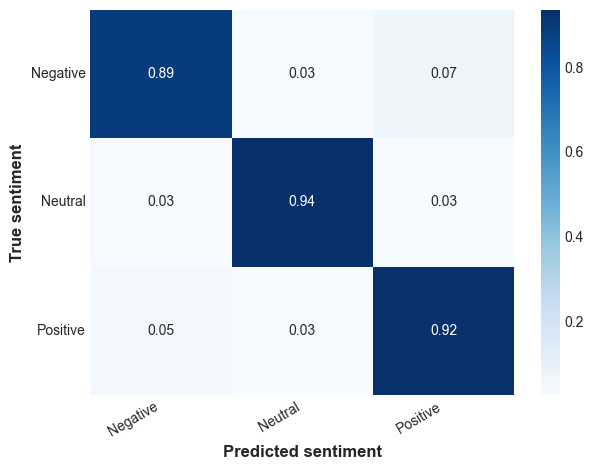

In [64]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred, normalize="true")
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [63]:
torch.save(bert_model.state_dict(), 'bert_model_eng.pth')

In [61]:
sample_text = "I buy a new house. This is great for me." 
sample_text = preprocessText(sample_text)
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)

input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

output = bert_model(input_ids, attention_mask)
_,preds = torch.max(output.logits, dim=1)
#print(preds)
print(class_names[preds])

#pd.set_option('display.max_colwidth', -1)
pd.DataFrame({
    "Text": sample_text,
    "Sentiment": class_names[preds]
},index=[0]).T

Neutral


c:\Users\romoc\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,0
Text,i buy a new house this is great for me
Sentiment,Neutral
